# Image Captioning

#### Contents
    1. Introduction
    2. Import Data and Pre-processing
    3. Make DataLoaders
    4. Implementation of Show and Tell Model
    5. Utils
    6. Train, Validation and Test
    7. Inference

## 1. Introduction
Image captioning is a task of generating a sentence that describes a given image. Vinyals et al. published a [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf), so-called 'Show and Tell. The paper proposed a basic model based on neural network, which is trainable end-to-end by an optimizer for the whole process and outperformed other previous models. <br/>

As it is mainly inspired by a model used for machine translation, it adopts an encoder-decoder architecture. For the encoder, a CNN model is used. It is pre-trained on ImageNet dataset, which is much more effective in extracting visual features from an image. For the decoder, RNN or its variants are used to generate sentences. In general, LSTM is used as it shows more robustness to long-term dependency problem and faster convergence than those of simple RNN. It is not necessarily pre-trained. 

<img src = './Images/ShowAndTellExample.png' width = 600>

## 2. Import Data and Pre-processing
### 2.1 Import Libraries

In [1]:
import io
import os
import numpy as np
import time
import random
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('punkt')

from itertools import chain
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /home/koo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2.2 Resize Images

In [2]:
image_dir = './Flickr8k/Flickr8k_Dataset/'
output_dir = './Flickr8k/Flickr8k_resized_image/'

image_size = [256,256]

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

images = os.listdir(image_dir)
num_images = len(images)
for i, image in enumerate(images):
    with open(os.path.join(image_dir, image), 'r+b') as f:
        with Image.open(f) as img:
            img = img.resize(image_size, Image.ANTIALIAS)
            img.save(os.path.join(output_dir, image), img.format)
            
    if (i+1) % 1000 == 0:
        print ("[{}/{}] images are resized and saved into '{}'."
               .format(i+1, num_images, output_dir))

[1000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[2000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[3000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[4000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[5000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[6000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[7000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[8000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.


### 2.3 Text Preprocessing

In [3]:
train_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt','r') as f:
    for image in f:
        train_image_list.append(image.strip())
        
val_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt','r') as f:
    for image in f:
        val_image_list.append(image.strip())
        
test_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt','r') as f:
    for image in f:
        test_image_list.append(image.strip())
        
image_caption=[]
with open('./Flickr8k/Flickr8k_text/Flickr8k.token.txt','r') as f:
    for image in f:
        image_caption.append(image)

In [4]:
annot={}
for i in range(0, len(image_caption), 5):
    ann=[]
    t1=image_caption[i].strip()
    for j in range(i, i+5):
        tmp=image_caption[j].strip()
        tmp=tmp.split('\t')
        ann.append([tmp[1].lower()])
    t1=t1.split('\t')
    annot[t1[0].split('#')[0]]=ann

In [5]:
cap_dict={}
for i in range(0, len(image_caption), 5):
    tmp=image_caption[i].strip()
    tmp=tmp.split('\t')
    cap_dict[tmp[0].split('#')[0]]=tmp[1].lower()

In [6]:
train_cap_dict={}
for image in train_image_list:
    train_cap_dict[image]=cap_dict[image]
    
val_cap_dict={}
for image in val_image_list:
    val_cap_dict[image]=cap_dict[image]
    
test_cap_dict={}
for image in test_image_list:
    test_cap_dict[image]=cap_dict[image]

In [7]:
train_token=[]
train_tok=[]
val_token=[]
test_token=[]

for (j,i) in train_cap_dict.items():
    train_token.append([j, word_tokenize(i)])
    train_tok.append(word_tokenize(i))
    
for (j,i) in val_cap_dict.items():
    val_token.append([j, word_tokenize(i)])
    
for (j,i) in test_cap_dict.items():
    test_token.append([j, word_tokenize(i)])

In [8]:
tokens = chain.from_iterable(train_tok)
word2idx = {token: idx for idx, token in enumerate(set(tokens))}

tokens = chain.from_iterable(train_tok)
idx2word = [token for idx, token in enumerate(set(tokens))]
idx2word = np.asarray(idx2word)

In [9]:
train_token_ids = [[word2idx[token] for token in x[1]] for x in train_token]
count = np.zeros(idx2word.shape)

for x in train_token_ids:
    for token in x:
        count[token] += 1
        
indices = np.argsort(-count)
idx2word = idx2word[indices]
count = count[indices]

In [10]:
word2idx = {token: idx for idx, token in enumerate(idx2word)}
print("Vocabulary size: "+str(len(word2idx)))

Vocabulary size: 3890


In [11]:
train_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in train_token]
val_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in val_token]
test_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in test_token]

In [12]:
word2idx['<unknown>'] = -4
word2idx['<start>'] = -3
word2idx['<end>'] = -2
word2idx['<pad>'] = -1

for (_, i) in word2idx.items():
    i+=4
    word2idx[_] = i

idx2word_dict={}
cnt=4

for i in idx2word:
    idx2word_dict[cnt]=i
    cnt+=1
    
idx2word_dict[0]='<unknown>'
idx2word_dict[1]='<start>'
idx2word_dict[2]='<end>'
idx2word_dict[3]='<pad>'

train_cap_length={}
for i in train_token:
    train_cap_length[i[0]]=len(i[1])+2
    
val_cap_length={}
for i in val_token:
    val_cap_length[i[0]]=len(i[1])+2
    
test_cap_length={}
for i in test_token:
    test_cap_length[i[0]]=len(i[1])+2

In [13]:
for i in train_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])

for i in val_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])
    
for i in test_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])

In [14]:
length=[]

for (i, j) in train_cap_length.items():
    length.append(j)

for n, i in enumerate(train_token):
    if (train_cap_length[i[0]] < max(length)):
        train_token_ids[n].extend(word2idx['<pad>'] for i in range(train_cap_length[i[0]], max(length)))
        
train_token_ids_dict={}

for n, i in enumerate(train_token):
    train_token_ids_dict[i[0]]=train_token_ids[n]

In [15]:
length=[]

for (i, j) in val_cap_length.items():
    length.append(j)

for n,i in enumerate(val_token):
    if (val_cap_length[i[0]] < max(length)):
        val_token_ids[n].extend(word2idx['<pad>'] for i in range(val_cap_length[i[0]], max(length)))
        
val_token_ids_dict={}

for n,i in enumerate(val_token):
    val_token_ids_dict[i[0]]=val_token_ids[n]

In [16]:
length=[]

for (i,j) in test_cap_length.items():
    length.append(j)
max_len=max(length)

for n,i in enumerate(test_token):
    if (test_cap_length[i[0]] < max(length)):
        test_token_ids[n].extend(word2idx['<pad>'] for i in range(test_cap_length[i[0]], max(length)))
        
test_token_ids_dict={}

for n,i in enumerate(test_token):
    test_token_ids_dict[i[0]]=test_token_ids[n]

In [17]:
np.save('./Flickr8k/Flickr8k_text/flickr8k_dictionary.npy',np.asarray(idx2word))

In [18]:
with io.open('./Flickr8k/Flickr8k_text/train_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(train_token_ids):
        f.write("%s " % train_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")
        
with io.open('./Flickr8k/Flickr8k_text/val_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(val_token_ids):
        f.write("%s " % val_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")

with io.open('./Flickr8k/Flickr8k_text/test_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(test_token_ids):
        f.write("%s " % test_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")

In [19]:
checkpoints = './Flickr8k/Flickr8k_checkpoints/'
results = './Flickr8k/Flickr8k_results/'

In [20]:
if not os.path.exists(checkpoints):
    os.mkdir(checkpoints)

In [21]:
if not os.path.exists(results):
    os.mkdir(results)

## 3. Make DataLoaders

In [22]:
class Flickr8k(Dataset):
    def __init__(self, image_list, cap_dictionary, cap_length, transform=None):
        
        self.image_path='./Flickr8k/Flickr8k_resized_image/'
        self.image_list=image_list
        self.transform=transform
        self.cap_dictionary=cap_dictionary
        self.cap_length=cap_length
    
    def __getitem__(self, index):
        image=self.image_list[index]
        img_open=Image.open(self.image_path+image).convert('RGB')
        
        if self.transform is not None:
            img_open=self.transform(img_open)
        
        caption = np.array(self.cap_dictionary[image])
        lengths = self.cap_length[image]
        
        return img_open, caption, lengths
        
    def __len__(self):
        return len(self.image_list)

In [23]:
def get_flickr8k_loader(purpose, batch_size):
    
    if purpose not in ['train', 'val', 'test']:
        raise NameError('Purpose should be train, val or test.')
    
    if purpose == 'train':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                        # Data Augmentation, 2048 times larger than original dataset
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        train_data=Flickr8k(train_image_list, train_token_ids_dict, train_cap_length, transform)
        train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader
        
    elif purpose == 'val':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        val_data=Flickr8k(val_image_list, val_token_ids_dict, val_cap_length, transform)
        val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=False)
        return val_loader
    
    elif purpose == 'test':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        test_data=Flickr8k(test_image_list, test_token_ids_dict, test_cap_length, transform)
        test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=False)
        return test_loader

In [24]:
batch_size = 16

train_loader = get_flickr8k_loader('train', batch_size)
val_loader = get_flickr8k_loader('val', batch_size)
test_loader = get_flickr8k_loader('test', batch_size)

## 4. Implementation of Show and Tell Model

<img src = './Images/ShowAndTellDiagram.png' width=600>

A GoogleNet architecture is used on the diagram but this tutorial uses `VGG19` and `ResNet152`, you can use either of it by changing the `encoder_model`. <br/>
As `ResNet152` performs better than `VGG19` in image classification, it shows better performance in visual feature extraction thus generates fruitful captions. The last fully connected layer is removed as we will not do classification. <br/>

<br> Decoder generates a sentence outputting word by word after the feature vector is passed from the encoder only once. You can compare the performance of `LSTM` and `GRU` by changing the `decoder_model`. A set of parameters, including `vocab_size`, `embed_dim`, `hidden_dim`, `num_layers`, `ratio`, outputs the best results.

In [25]:
class EncoderCNN(nn.Module):
    def __init__(self, encoder_model, embed_size):
        super(EncoderCNN, self).__init__()
        
        self.encoder_model = encoder_model
        
        if encoder_model == 'VGG19':
            vgg19 = models.vgg19_bn(pretrained=True)
            modules = list(vgg19.children())[:-1]
            self.feature_extractor = nn.Sequential(*modules)
            self.linear = nn.Linear(vgg19.classifier[0].in_features, embed_size)
        
        elif encoder_model == 'ResNet152':
            resnet = models.resnet152(pretrained=True)
            modules = list(resnet.children())[:-1]
            self.feature_extractor = nn.Sequential(*modules)
            self.linear = nn.Linear(resnet.fc.in_features, embed_size)
            
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)

    def forward(self, images):
        with torch.no_grad():
            features = self.feature_extractor(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, decoder_model, vocab_size, embed_size, hidden_size, num_layers, ratio, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        
        self.decoder_model = decoder_model
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        if decoder_model == "LSTM":
            self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        elif decoder_model == "GRU":
            self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.dropout = nn.Dropout(ratio)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions.long())
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed)
        
        outputs = self.linear(self.dropout(hiddens[0]))
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.rnn(inputs, states)           # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [27]:
vocab_size = len(word2idx)
embed_dim = 512
hidden_dim = 1024
num_layers = 1
ratio = 0.5

encoder = EncoderCNN("ResNet152", embed_dim).to(device)
decoder = DecoderRNN("LSTM", vocab_size, embed_dim, hidden_dim, num_layers, ratio).to(device)

In [28]:
training_losses, val_losses, test_losses = [], [], []
bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []

## 5. Utils
A series of utils are defined for furthrer usage.

In [29]:
def sorting(image,caption,length):
    srt=length.sort(descending=True)
    image=image[srt[1]]
    caption=caption[srt[1]]
    length=srt[0]
    return image, caption, length

In [30]:
def sentence_generation(image, encoder, decoder):
    image = image.to(device)
    feature = encoder(image)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    caption = []
    
    for idx in sampled_ids:
        word = idx2word_dict[idx]
        caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(caption)
    
    return sentence

In [31]:
def load_image(image_path):
    image = Image.open(image_path)
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    image = transform(image).unsqueeze(0)
    
    return image

In [32]:
def getRandomFile(img_list):
    index = random.randrange(0, len(img_list))
    return img_list[index]

In [33]:
def save_checkpoint(epoch, encoder, decoder, optimizer, bleu4, is_best):
    
    state = {'epoch': epoch,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'optimizer': optimizer}
    
    filename = 'checkpoint_flickr8k_'+ encoder.encoder_model + '_' + decoder.decoder_model + '.pth.tar'
    torch.save(state, filename)
    
    if is_best:
        torch.save(state, 'BEST_' + filename)

## 6. Training, Validation and Test

In [34]:
# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

In [35]:
def training(data_loader, encoder, decoder, criterion, optimizer, epoch, num_epochs):
    
    encoder.train()
    decoder.train()
    
    for i, (images, captions, lengths) in enumerate(train_loader):
        
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        
        encoder.zero_grad()
        decoder.zero_grad()
        
        images, captions, lengths = sorting(images, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Training | Epochs [{}/{}] | Step [{}/{}] | Loss: {:.4f} | Perplexity: {:.4f}'
                  .format(epoch+1, num_epochs, i, len(train_loader), loss.item(), np.exp(loss.item())))

In [36]:
def validation(data_loader, encoder, decoder, criterion, epoch, num_epochs):
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    encoder.eval()
    decoder.eval()
    
    for i, (images,captions,lengths) in enumerate(data_loader):
        
        images = images.to(device)
        captions = captions.to(device)

        images, captions, lengths = sorting(images, captions, lengths)

        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()

        with torch.no_grad():
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            
        if i % 100 == 0:
            val_losses.append(loss.item())
  
    total, bleu1, bleu2, bleu3, bleu4 = 0, 0, 0, 0, 0

    with torch.no_grad():        
        hypothesis = []
        for i in range(len(val_image_list)):

            file=val_image_list[i]
            image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))
            
            sentence = sentence_generation(image, encoder, decoder)
            hypothesis.append([file,sentence])            
            org_sentence=annot[file]           
            generated=word_tokenize(str(sentence))

            actual=[]
            for j in org_sentence:
                actual.append(word_tokenize(j[0]))
            
            score_bleu1 = sentence_bleu(actual, generated, weights=(1, 0, 0, 0))
            score_bleu2 = sentence_bleu(actual, generated, weights=(0, 1, 0, 0))
            score_bleu3 = sentence_bleu(actual, generated, weights=(0, 0, 1, 0))
            score_bleu4 = sentence_bleu(actual, generated, weights=(0, 0, 0, 1))
            
            bleu1 += score_bleu1
            bleu2 += score_bleu2    
            bleu3 += score_bleu3
            bleu4 += score_bleu4
            total +=1
            
    bleu1_list.append(100*bleu1/total)
    bleu2_list.append(100*bleu2/total)
    bleu3_list.append(100*bleu3/total)
    bleu4_list.append(100*bleu4/total)
    
    print("Validation | Epoch [{}/{}] | Loss: {:.4f} | BLEU 1: {:.4f} | BLEU 2: {:.4f} | BLEU 3: {:.4f} | BLEU 4: {:.4f}".
          format(epoch+1, num_epochs, np.average(val_losses), np.average(bleu1_list), np.average(bleu2_list), np.average(bleu3_list), np.average(bleu4_list)))
    
    cur_bleu4 = np.average(bleu4_list)
    return cur_bleu4 

In [37]:
best_bleu4 = 0.
num_epochs = 50

torch.cuda.empty_cache()
for epoch in range(num_epochs):
    training(train_loader, encoder, decoder, criterion, optimizer, epoch, num_epochs)
    recent_bleu4 = validation(val_loader, encoder, decoder, criterion, epoch, num_epochs)
    
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    
    print("Best BLEU4 so far is {:.4f}.\n".format(best_bleu4))
    save_checkpoint(epoch, encoder, decoder, optimizer, recent_bleu4, is_best)

Training | Epochs [1/50] | Step [0/375] | Loss: 8.2781 | Perplexity: 3936.7827
Training | Epochs [1/50] | Step [100/375] | Loss: 4.6805 | Perplexity: 107.8197
Training | Epochs [1/50] | Step [200/375] | Loss: 3.9357 | Perplexity: 51.2002
Training | Epochs [1/50] | Step [300/375] | Loss: 4.0933 | Perplexity: 59.9373
Validation | Epoch [1/50] | Loss: 4.1390 | BLEU 1: 35.1726 | BLEU 2: 9.7188 | BLEU 3: 2.6489 | BLEU 4: 0.9747
Best BLEU4 so far is 0.9747.

Training | Epochs [2/50] | Step [0/375] | Loss: 3.7425 | Perplexity: 42.2018
Training | Epochs [2/50] | Step [100/375] | Loss: 3.5514 | Perplexity: 34.8619
Training | Epochs [2/50] | Step [200/375] | Loss: 3.7378 | Perplexity: 42.0042
Training | Epochs [2/50] | Step [300/375] | Loss: 3.2634 | Perplexity: 26.1387
Validation | Epoch [2/50] | Loss: 3.9786 | BLEU 1: 35.5533 | BLEU 2: 10.3875 | BLEU 3: 3.0950 | BLEU 4: 1.1436
Best BLEU4 so far is 1.1436.

Training | Epochs [3/50] | Step [0/375] | Loss: 3.8458 | Perplexity: 46.7975
Training | 

Training | Epochs [19/50] | Step [0/375] | Loss: 1.7343 | Perplexity: 5.6647
Training | Epochs [19/50] | Step [100/375] | Loss: 1.6836 | Perplexity: 5.3852
Training | Epochs [19/50] | Step [200/375] | Loss: 1.7322 | Perplexity: 5.6533
Training | Epochs [19/50] | Step [300/375] | Loss: 1.8080 | Perplexity: 6.0984
Validation | Epoch [19/50] | Loss: 3.4413 | BLEU 1: 36.8321 | BLEU 2: 12.5205 | BLEU 3: 4.6623 | BLEU 4: 1.9754
Best BLEU4 so far is 1.9754.

Training | Epochs [20/50] | Step [0/375] | Loss: 1.6763 | Perplexity: 5.3457
Training | Epochs [20/50] | Step [100/375] | Loss: 1.7713 | Perplexity: 5.8785
Training | Epochs [20/50] | Step [200/375] | Loss: 1.5797 | Perplexity: 4.8534
Training | Epochs [20/50] | Step [300/375] | Loss: 1.6239 | Perplexity: 5.0730
Validation | Epoch [20/50] | Loss: 3.4398 | BLEU 1: 36.9000 | BLEU 2: 12.5909 | BLEU 3: 4.7011 | BLEU 4: 1.9965
Best BLEU4 so far is 1.9965.

Training | Epochs [21/50] | Step [0/375] | Loss: 1.5450 | Perplexity: 4.6881
Training | 

Training | Epochs [37/50] | Step [0/375] | Loss: 0.8569 | Perplexity: 2.3560
Training | Epochs [37/50] | Step [100/375] | Loss: 0.9400 | Perplexity: 2.5600
Training | Epochs [37/50] | Step [200/375] | Loss: 0.8806 | Perplexity: 2.4123
Training | Epochs [37/50] | Step [300/375] | Loss: 0.9329 | Perplexity: 2.5418
Validation | Epoch [37/50] | Loss: 3.5240 | BLEU 1: 37.4508 | BLEU 2: 13.2897 | BLEU 3: 5.2425 | BLEU 4: 2.2425
Best BLEU4 so far is 2.2425.

Training | Epochs [38/50] | Step [0/375] | Loss: 0.7743 | Perplexity: 2.1690
Training | Epochs [38/50] | Step [100/375] | Loss: 0.8377 | Perplexity: 2.3111
Training | Epochs [38/50] | Step [200/375] | Loss: 0.8700 | Perplexity: 2.3869
Training | Epochs [38/50] | Step [300/375] | Loss: 0.8867 | Perplexity: 2.4270
Validation | Epoch [38/50] | Loss: 3.5334 | BLEU 1: 37.4583 | BLEU 2: 13.3057 | BLEU 3: 5.2522 | BLEU 4: 2.2423
Best BLEU4 so far is 2.2425.

Training | Epochs [39/50] | Step [0/375] | Loss: 0.8628 | Perplexity: 2.3699
Training | 

In [38]:
def test(data_loader, encoder, decoder, criterion):
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    encoder.eval()
    decoder.eval()
    
    for i, (images, captions, lengths) in enumerate(data_loader):
        
        images = images.to(device)
        captions = captions.to(device)

        images, captions, lengths = sorting(images, captions, lengths)

        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()

        with torch.no_grad():
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            
        if i % 1000 == 0:
            test_losses.append(loss.item())
  
    total, bleu1, bleu2, bleu3, bleu4 = 0, 0, 0, 0, 0

    with torch.no_grad():        
        hypothesis = []
        for i in range(len(test_image_list)):

            file=test_image_list[i]
            image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))
            
            sentence = sentence_generation(image, encoder, decoder)
            hypothesis.append([file,sentence])            
            org_sentence=annot[file]            
            generated=word_tokenize(str(sentence))

            actual=[]
            for j in org_sentence:
                actual.append(word_tokenize(j[0]))   

            score_bleu1 = sentence_bleu(actual, generated, weights=(1, 0, 0, 0))
            score_bleu2 = sentence_bleu(actual, generated, weights=(0, 1, 0, 0))
            score_bleu3 = sentence_bleu(actual, generated, weights=(0, 0, 1, 0))
            score_bleu4 = sentence_bleu(actual, generated, weights=(0, 0, 0, 1))
            
            bleu1 += score_bleu1
            bleu2 += score_bleu2    
            bleu3 += score_bleu3
            bleu4 += score_bleu4
            total +=1
            
    bleu1_list.append(100*bleu1/total)
    bleu2_list.append(100*bleu2/total)
    bleu3_list.append(100*bleu3/total)
    bleu4_list.append(100*bleu4/total)
    
    print("Test | Loss: {:.4f} | BLEU 1: {:.4f} | BLEU 2: {:.4f} | BLEU 3: {:.4f} | BLEU 4: {:.4f}\n".
          format(np.average(test_losses), np.average(bleu1_list), np.average(bleu2_list), np.average(bleu3_list), np.average(bleu4_list)))

In [39]:
model = 'BEST_checkpoint_flickr8k_{}_{}.pth.tar'.format(encoder.encoder_model, decoder.decoder_model)

checkpoint = torch.load(model)

encoder = checkpoint['encoder']
decoder = checkpoint['decoder']

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()

DecoderRNN(
  (embed): Embedding(3894, 512)
  (rnn): LSTM(512, 1024, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=1024, out_features=3894, bias=True)
)

In [40]:
test(test_loader, encoder, decoder, criterion)

Test | Loss: 3.6051 | BLEU 1: 37.3726 | BLEU 2: 13.3076 | BLEU 3: 5.2893 | BLEU 4: 2.2273



# 7. Inference
As the dataset is quite small (1GB), model may not be able to generate appropriate sentences to all images.

3587781729_bd21ce7b11.jpg
<start> a boy wearing a red shirt and blue crocs shoes is leaping into the air . <end>


[['this picture shows a blond-haired boy and brown-haired boy smiling while swinging on a tire swing .'],
 ['two children are laughing and playing in a tire swing at a park .'],
 ['two child share a swing in a playground .'],
 ['two kids are swinging together on a tire swing .'],
 ['two kids enjoy a tire swing .']]

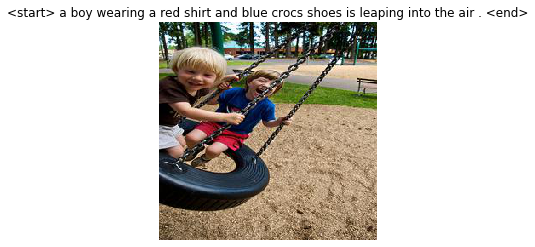

In [41]:
file = '3587781729_bd21ce7b11.jpg'
image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))
print(file)

sentence = sentence_generation(image, encoder, decoder)
print(sentence)
image = Image.open('./Flickr8k/Flickr8k_resized_image/'+ str(file))
plt.savefig("./Flickr8k/results.png")

plt.title(sentence)
plt.imshow(np.asarray(image))
plt.axis("off")

org_sentence=annot[file]
org_sentence